In [2]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy .stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter, butter, filtfilt

In [3]:
def explore_hdf5(file_path):
    """
    Recursively explore the structure of an HDF5 file (.mat v7.3 format).
    
    Parameters:
        file_path (str): Path to the HDF5 (.mat) file.
    """
    def print_hdf5_structure(name, obj):
        print(f"{name}: {obj}")

    with h5py.File(file_path, 'r') as mat_file:
        print(f"Structure of {file_path}:")
        mat_file.visititems(print_hdf5_structure)

def get_hdf5_variable(file_path, variable_path):
    """
    Access a variable in an HDF5 file, even if nested.

    Parameters:
        file_path (str): Path to the HDF5 file.
        variable_path (str): Full path to the variable within the file (e.g., "group/subgroup/variable").
        
    Returns:
        np.array: The signal data.
    """
    with h5py.File(file_path, 'r') as mat_file:
        obj = mat_file
        for part in variable_path.split('/'):
            obj = obj[part]
        return np.array(obj).squeeze() 

pid_signal_file = r"C:\\Users\\amirr\\Py\\AP\\PID_EB50_Plume_014_1.mat"
sensor_signal_file = r"C:\\Users\\amirr\\Py\\AP\\MICS_EB50_Plume_014_1.mat"

print("Exploring PID Signal File:")
explore_hdf5(pid_signal_file)

print("\nExploring Sensor Signal File:")
explore_hdf5(sensor_signal_file)


Exploring PID Signal File:
Structure of C:\\Users\\amirr\\Py\\AP\\PID_EB50_Plume_014_1.mat:
PID_EB50_Plume_014_1__1__Ch1: <HDF5 group "/PID_EB50_Plume_014_1__1__Ch1" (9 members)>
PID_EB50_Plume_014_1__1__Ch1/comment: <HDF5 dataset "comment": shape (2,), type "<u8">
PID_EB50_Plume_014_1__1__Ch1/interval: <HDF5 dataset "interval": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/length: <HDF5 dataset "length": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/offset: <HDF5 dataset "offset": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/scale: <HDF5 dataset "scale": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/start: <HDF5 dataset "start": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/title: <HDF5 dataset "title": shape (5, 1), type "<u2">
PID_EB50_Plume_014_1__1__Ch1/units: <HDF5 dataset "units": shape (5, 1), type "<u2">
PID_EB50_Plume_014_1__1__Ch1/values: <HDF5 dataset "values": shape (1, 561554), type "<f8">
PID_EB50_Plume_014_1__1__Ch2: <HDF5 g

In [4]:
# Variable paths for PID, sensor, and their respective trigger channels
pid_variable_path = 'PID_EB50_Plume_014_1__1__Ch4/values'  
sensor_variable_path = 'MICS_EB50_Plume_014_1__1__Ch5/values'  
pid_trigger_variable_path = 'PID_EB50_Plume_014_1__1__Ch8/values'
sensor_trigger_variable_path = 'MICS_EB50_Plume_014_1__1__Ch8/values'

# Load signals
pid_signal = get_hdf5_variable(pid_signal_file, pid_variable_path)
sensor_signal = get_hdf5_variable(sensor_signal_file, sensor_variable_path)
pid_trigger_signal = get_hdf5_variable(pid_signal_file, pid_trigger_variable_path)
sensor_trigger_signal = get_hdf5_variable(sensor_signal_file, sensor_trigger_variable_path)

# Sampling rate
sampling_rate = 10000 


In [5]:
# Identify trigger spikes for PID and MICS (threshold-based detection)
pid_trigger_threshold = 0.8 * np.max(pid_trigger_signal)
sensor_trigger_threshold = 0.8 * np.max(sensor_trigger_signal)

pid_trigger_spikes = np.where(pid_trigger_signal > pid_trigger_threshold)[0]
sensor_trigger_spikes = np.where(sensor_trigger_signal > sensor_trigger_threshold)[0]


# Define kernel function
def kernel(t, tau1, tau2):
    return np.exp(-t / tau1) - np.exp(-t / tau2) #tau1 - decay, tau2 - rise

def kernel_MOX(t, tau1, tau2, tau3, tau4):
    return (1/(t*tau1 +1))*np.exp(-t / tau3) - (1/(t*tau2+1))*np.exp(-t / tau4) #tau1 - decay, tau2 - rise


tau1, tau2 = 1 , 0.05
# tau1, tau2, tau3, tau4 = 14,2 ,1, 0.05	#KMOX
kernel_time = np.linspace(0, 1, len(sensor_signal))
kernel_signal = kernel(kernel_time, tau1, tau2)
# kernel_signal = kernel_MOX(kernel_time, tau1, tau2, tau3, tau4)

# FFT of the sensor signal and kernel
fft_sensor = np.fft.fft(sensor_signal)
fft_kernel = np.fft.fft(kernel_signal, n=len(sensor_signal))

# Deconvolution
fft_deconvolved = fft_sensor / (fft_kernel + 1e-10)  # Avoid division by zero
deconvolved_signal = np.fft.ifft(fft_deconvolved).real

# Normalize signals
sensor_signal_normalized = sensor_signal / np.max(np.abs(sensor_signal))
deconvolved_signal_normalized = deconvolved_signal / np.max(np.abs(deconvolved_signal))
pid_signal_normalized = pid_signal / np.max(np.abs(pid_signal))

# Smooth deconvolved signal
window_size = 10
deconvolved_signal_smoothed = gaussian_filter1d(deconvolved_signal_normalized, sigma=9)  # Adjust sigma for smoothing strength
# deconvolved_signal_smoothed = np.convolve(deconvolved_signal_normalized, np.ones(window_size)/window_size, mode='same')
# deconvolved_signal_smoothed = savgol_filter(deconvolved_signal_normalized, window_length=51, polyorder=2)

# Center and calibrate signals
pid_signal_centered = pid_signal_normalized - np.mean(pid_signal_normalized)
deconvolved_signal_centered = deconvolved_signal_smoothed - np.mean(deconvolved_signal_smoothed)
scaling_factor = np.max(np.abs(pid_signal_centered)) / np.max(np.abs(deconvolved_signal_centered))
deconvolved_signal_calibrated = deconvolved_signal_centered * scaling_factor


In [6]:
def correct_baseline(signal, threshold_ratio):
    """
    Corrects the baseline of a signal by subtracting the average value 
    of the signal below a specified threshold.

    Parameters:
        signal (np.array): Input signal to correct.
        threshold_ratio (float): Ratio of max(signal) to define the baseline threshold.

    Returns:
        np.array: Signal with corrected baseline.
    """
    # Define the threshold
    threshold = threshold_ratio * np.max(signal)
    # print(threshold)
    
    # Identify values below the threshold
    low_values = signal[signal < threshold]

    # Calculate the average of low values
    baseline = np.mean(low_values) if len(low_values) > 0 else 0
    
    # Subtract the baseline from the signal and remove negative values
    corrected_signal = np.maximum((signal - baseline), 0)
    # corrected_signal = signal - baseline
    return corrected_signal

deconvolved_signal_calibrated = correct_baseline(deconvolved_signal_calibrated, threshold_ratio=0.1)

In [7]:
# Parameters
trigger_threshold = 0.8
trigger_duration = 2  # seconds
offset = 0.01  # offset after trigger
Tmax = 0.7

# File paths
output_folder = r"C:\Users\amirr\Py\AP\Output"

# Deduplicate trigger indices for PID and sensor
pid_trigger_indices = np.where(pid_trigger_signal > trigger_threshold)[0]
pid_deduplicated_indices = [pid_trigger_indices[0]] + [
    idx for i, idx in enumerate(pid_trigger_indices[1:]) if idx - pid_trigger_indices[i] > int(0.1 * sampling_rate)
]

sensor_trigger_indices = np.where(sensor_trigger_signal > trigger_threshold)[0]
sensor_deduplicated_indices = [sensor_trigger_indices[0]] + [
    idx for i, idx in enumerate(sensor_trigger_indices[1:]) if idx - sensor_trigger_indices[i] > int(0.1 * sampling_rate)
]

samples_to_include = int(trigger_duration * sampling_rate)
offset_samples = int(offset * sampling_rate)


In [8]:
# Extract repeats for PID signals
pid_repeats = {
    f"repeat_{i + 1}": pid_signal_centered[idx + offset_samples:idx + offset_samples + samples_to_include]
    for i, idx in enumerate(pid_deduplicated_indices)
    if idx + offset_samples + samples_to_include <= len(pid_signal)
}

# Extract repeats for deconvolved signals
deconvolved_repeats = {
    f"repeat_{i + 1}": deconvolved_signal_calibrated[idx + offset_samples:idx + offset_samples + samples_to_include]
    for i, idx in enumerate(sensor_deduplicated_indices)
    if idx + offset_samples + samples_to_include <= len(deconvolved_signal_calibrated)
}

# Normalize repeats
pid_normalized_repeats = {
    key: (data - np.min(data)) / (np.max(data) - np.min(data)) for key, data in pid_repeats.items()
}
deconvolved_normalized_repeats = {
    key: (data - np.min(data)) / (np.max(data) - np.min(data)) for key, data in deconvolved_repeats.items()
}

# Correlations between each pair of PID and MICS repeats
correlations_pid_mics = {
    (pid_key, mics_key): pearsonr(pid_normalized_repeats[pid_key][:len(deconvolved_normalized_repeats[mics_key])],
                                  deconvolved_normalized_repeats[mics_key][:len(pid_normalized_repeats[pid_key])])[0]
    for pid_key in pid_normalized_repeats.keys() 
    for mics_key in deconvolved_normalized_repeats.keys()
}

# Calculate correlations between the first repeat of each signal
reference_pid_signal = list(pid_repeats.values())[0]  # Use the first PID repeat as reference
reference_pid_normalized = (reference_pid_signal - np.min(reference_pid_signal)) / (np.max(reference_pid_signal) - np.min(reference_pid_signal))

correlations_with_first = {
    key: pearsonr(data[:len(reference_pid_normalized)], reference_pid_normalized[:len(data)])[0]
    for key, data in deconvolved_normalized_repeats.items()
}


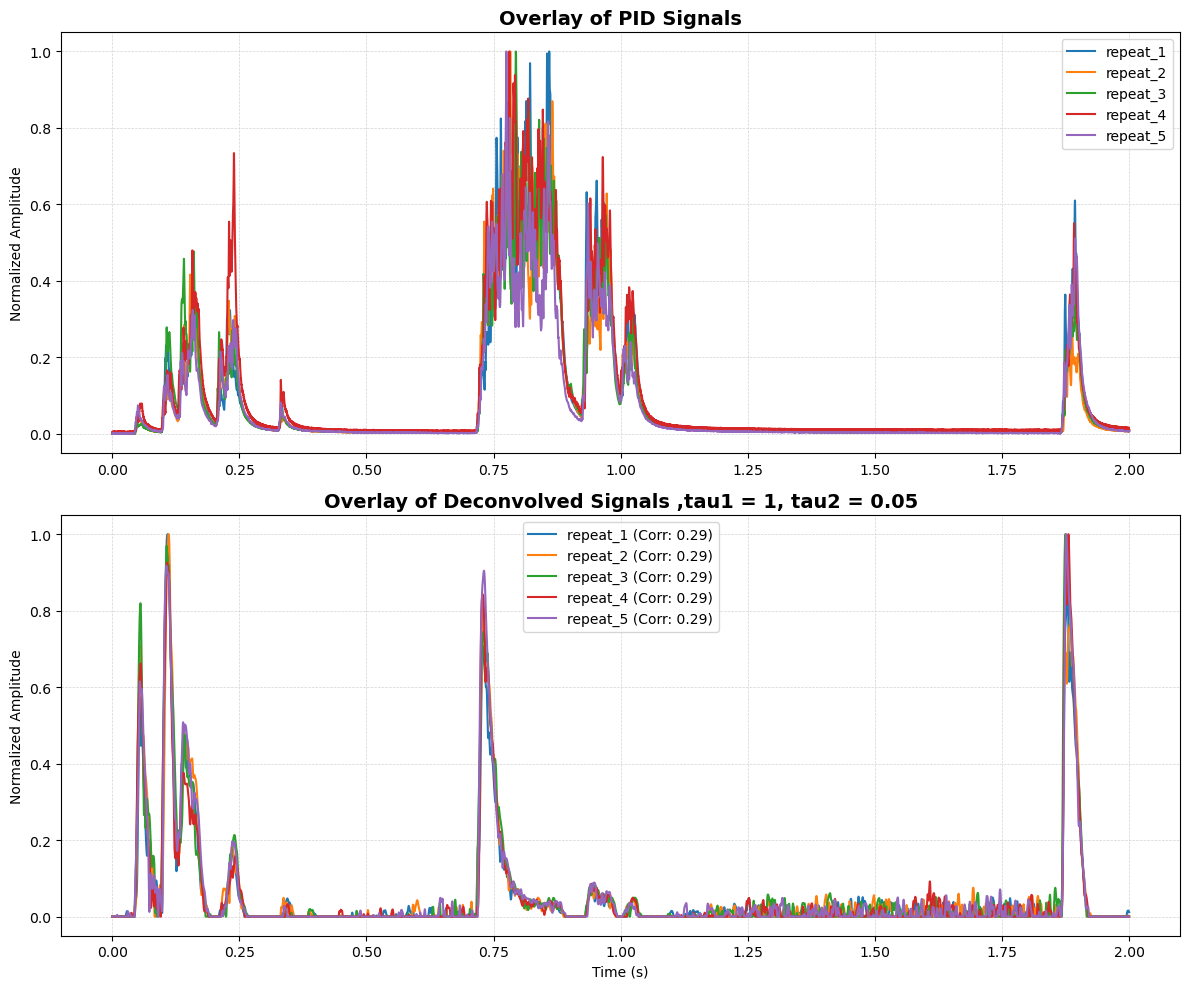

In [9]:
# Time axis for plotting
time = np.arange(samples_to_include) / sampling_rate

# Plot 1: Overlay of PID and deconvolved signals
fig1, axs = plt.subplots(2, 1, figsize=(12, 10))
for key, data in pid_normalized_repeats.items():
    axs[0].plot(time, data, label=f"{key}", linewidth=1.5)
axs[0].set_title(f"Overlay of PID Signals", fontsize=14, fontweight='bold')
axs[0].set_ylabel("Normalized Amplitude")
axs[0].legend(fontsize=10, loc="upper right")
axs[0].grid(color='lightgrey', linestyle='--', linewidth=0.5)

for key, data in deconvolved_normalized_repeats.items():
    axs[1].plot(time, data, label=f"{key} (Corr: {correlations_pid_mics.get((list(pid_normalized_repeats.keys())[0], key), 'N/A'):.2f})")
axs[1].set_title(f"Overlay of Deconvolved Signals ,tau1 = {tau1}, tau2 = {tau2}", fontsize=14, fontweight='bold')
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Normalized Amplitude")
axs[1].legend(fontsize=10)
axs[1].grid(color='lightgrey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, f"PID_vs_Deconvolved_TMax_{Tmax}_Overlay_gau5.png"), dpi=300)
plt.show()


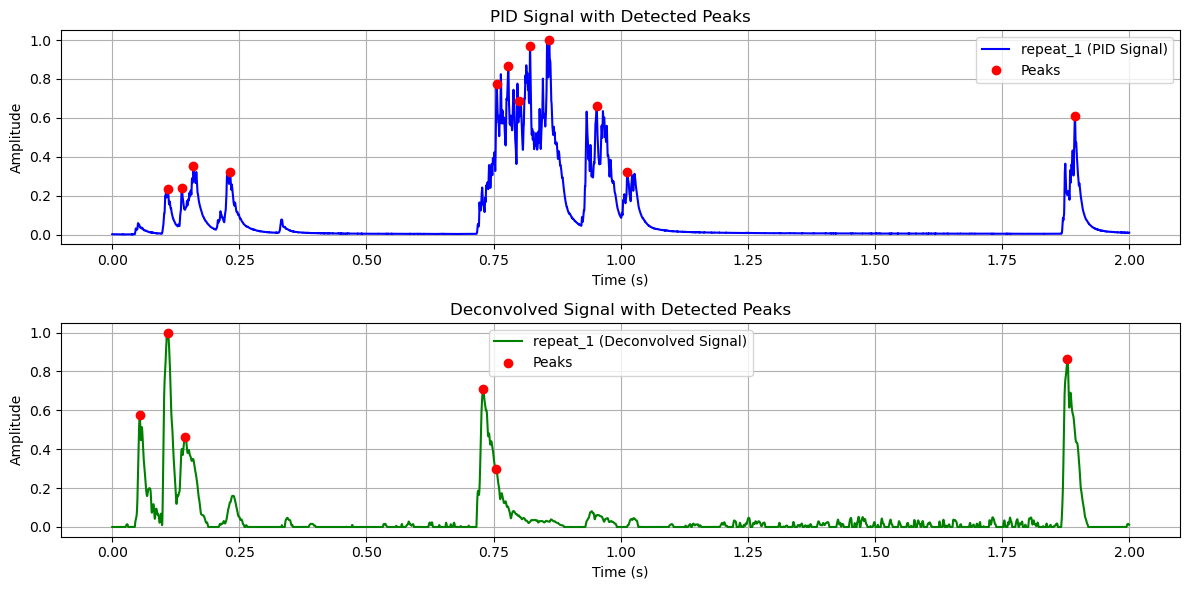

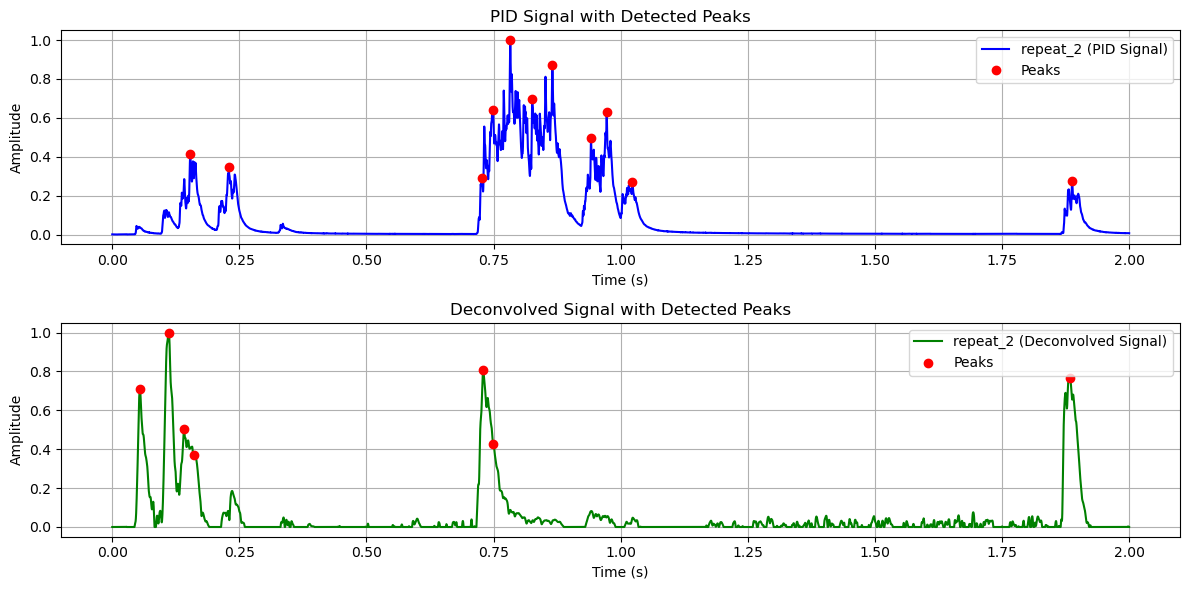

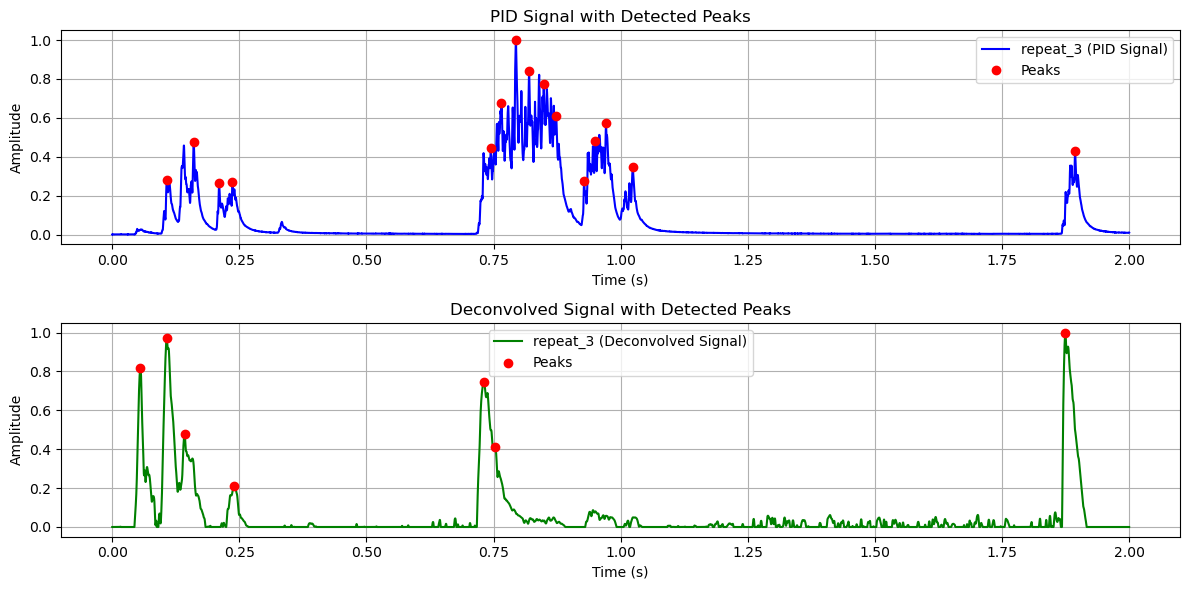

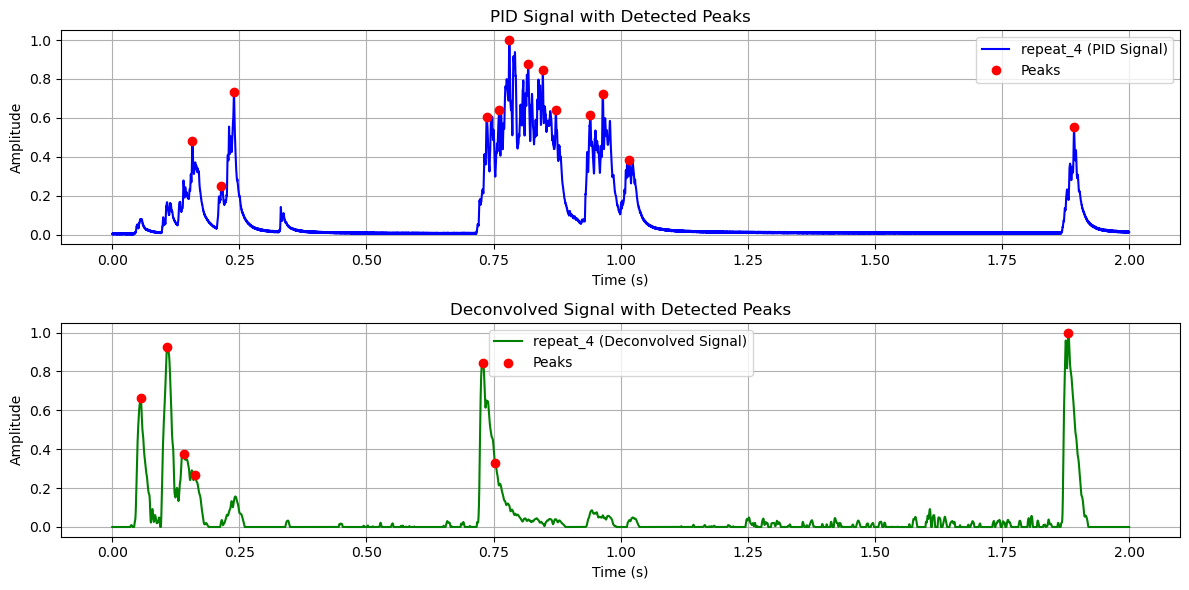

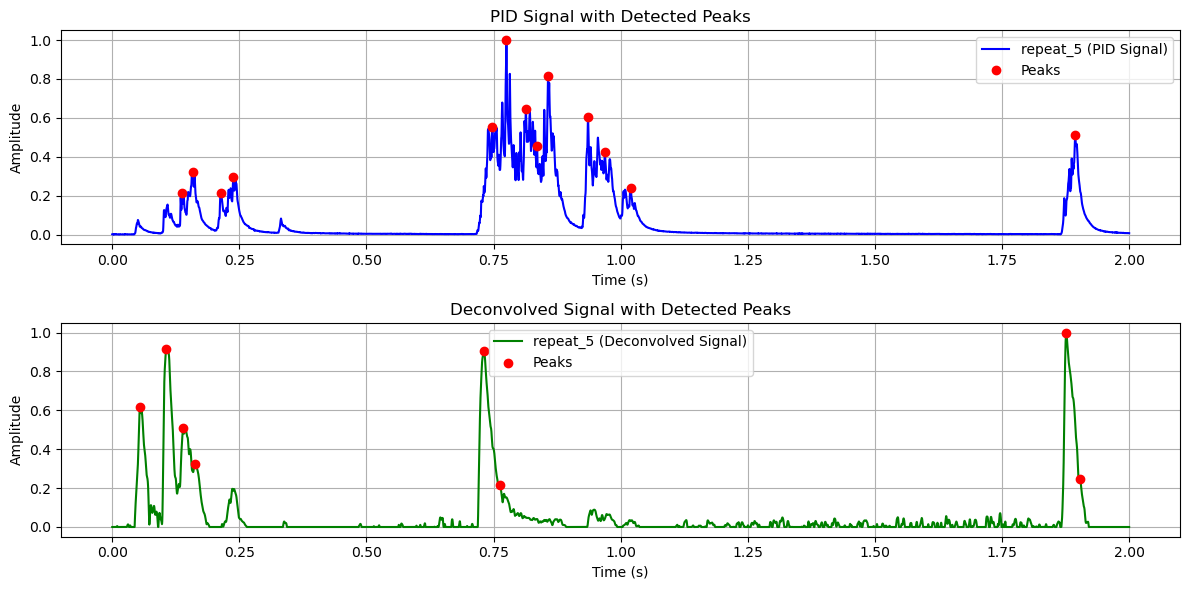

In [10]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Set thresholds
min_peak_height = 0.21  # Minimum height of peaks
min_peak_distance = int(0.02 * sampling_rate)  # Minimum distance between peaks in samples
prominance_value = 0.05

# Function to detect and plot peaks for each repeat
def plot_with_peaks(pid_repeats, deconvolved_repeats, time_axis, save_folder=None):
    """
    Plot PID and Deconvolved signals with detected peaks for each repeat.

    Parameters:
        pid_repeats (dict): Dictionary of PID signal repeats.
        deconvolved_repeats (dict): Dictionary of deconvolved signal repeats.
        time_axis (np.array): Time axis for plotting.
        save_folder (str): Path to save the plots (optional).
    """
    for i, (pid_key, pid_data) in enumerate(pid_repeats.items()):
        deconvolved_key = list(deconvolved_repeats.keys())[i]
        deconvolved_data = deconvolved_repeats[deconvolved_key]

        # Detect peaks in PID and Deconvolved signals
        pid_peaks, _ = find_peaks(pid_data, height=min_peak_height, distance=min_peak_distance,prominence= prominance_value)
        deconvolved_peaks, _ = find_peaks(deconvolved_data, height=min_peak_height, distance=min_peak_distance)

        # Plot signals with peaks
        plt.figure(figsize=(12, 6))

        # PID Signal
        plt.subplot(2, 1, 1)
        plt.plot(time_axis, pid_data, label=f"{pid_key} (PID Signal)", color='blue')
        plt.plot(time_axis[pid_peaks], pid_data[pid_peaks], "ro", label="Peaks")
        plt.title("PID Signal with Detected Peaks")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

        # Deconvolved Signal
        plt.subplot(2, 1, 2)
        plt.plot(time_axis, deconvolved_data, label=f"{deconvolved_key} (Deconvolved Signal)", color='green')
        plt.plot(time_axis[deconvolved_peaks], deconvolved_data[deconvolved_peaks], "ro", label="Peaks")
        plt.title("Deconvolved Signal with Detected Peaks")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

        # Save or show the plot
        plt.tight_layout()
        if save_folder:
            plt.savefig(f"{save_folder}/Repeat_{i + 1}_Peaks.png", dpi=300)
        else:
            plt.show()
time_axis = np.arange(len(next(iter(pid_normalized_repeats.values())))) / sampling_rate

# Call the function to plot each repeat
plot_with_peaks(pid_normalized_repeats, deconvolved_normalized_repeats, time_axis)

C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[1.0840542  1.08505425 1.0860543  1.08705435 1.0880544  1.08905445
 1.0900545  1.09105455 1.0920546  1.09305465 1.0940547  1.09505475
 1.0960548  1.09705485 1.0980549  1.09905495 1.100055   1.10105505
 1.1020551  1.10305515] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  integral = simpson(signal[left_base:right_base], t[left_base:right_base])
C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[1.35506775 1.3560678  1.35706785 1.3580679  1.35906795 1.360068
 1.36106805 1.3620681  1.36306815 1.3640682  1.36506825 1.3660683
 1.36706835 1.3680684  1.36906845 1.3700685  1.37106855 1.3720686
 1.37306865 1.3740687 ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passi

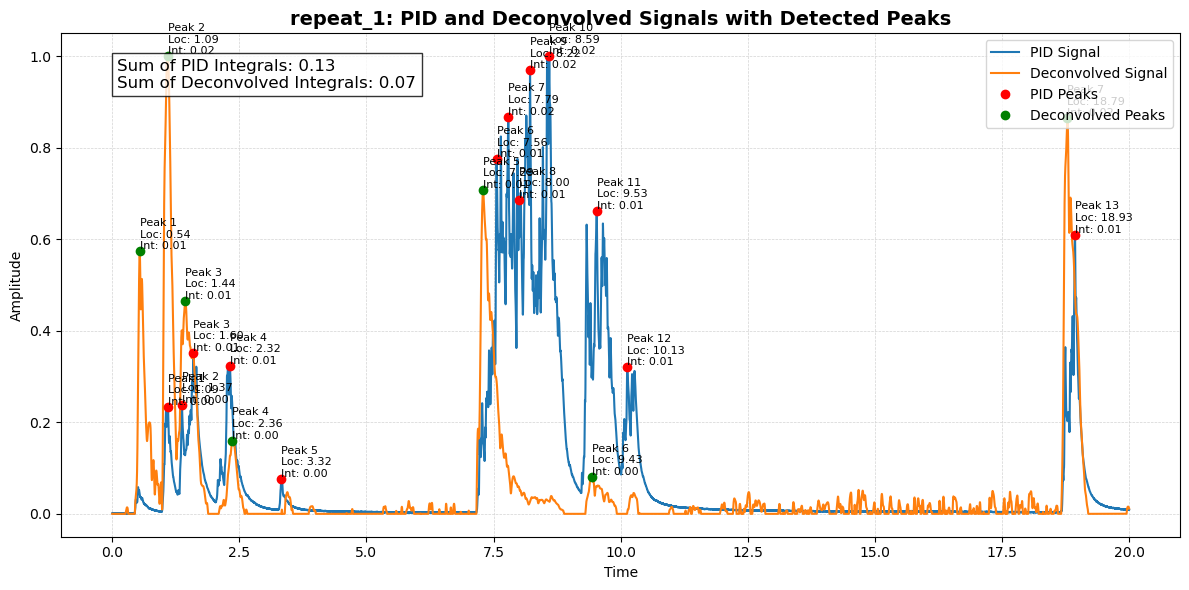

repeat_1 PID Dynamics (a, b, c): [array([ 6.59684679e+01,  1.30497522e-02, -6.48062469e+01]), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), array([-98.04264943,  14.1035239 ,   0.7387066 ]), array([-54.27061826,   8.09701838,   0.82308915]), array([-189.79444769,   24.86102008,    0.63562889]), array([-100.11370389,   13.29802795,    0.87211624]), array([-40.87668056,   5.87192029,   0.95771334]), array([1.00267764e+05, 1.00679264e+04, 6.31482895e-01]), array([-4.62684444e+03,  4.57926544e+02,  3.02028488e-01]), array([-5.92182829e+06,  9.62887798e+05,  5.75918860e-01])]
repeat_1 Deconvolved Dynamics (a, b, c): [array([ 2.14821604e+01, -1.82769158e-02, -2.11369146e+01]), array([ 2.15821432,  0.0185006 , -1.11748102]), (nan, nan, nan), (nan, nan, nan), array([8.78720512e+02, 1.66774093e+02, 7.02888145e-01]), array([-3.14407148e+03,  3.34559297e+02,  8.01023926e-02]), array([2.37212606e+05, 1.11855584e+05, 8.56846340e-01])]


C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[1.04305215 1.0440522  1.04505225 1.0460523  1.04705235 1.0480524
 1.04905245 1.0500525  1.05105255 1.0520526  1.05305265 1.0540527
 1.05505275 1.0560528  1.05705285 1.0580529  1.05905295 1.060053
 1.06105305 1.0620531 ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  integral = simpson(signal[left_base:right_base], t[left_base:right_base])
C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[1.52307615 1.5240762  1.52507625 1.5260763  1.52707635 1.5280764
 1.52907645 1.5300765  1.53107655 1.5320766  1.53307665 1.5340767
 1.53507675 1.5360768  1.53707685 1.5380769  1.53907695 1.540077
 1.54107705 1.5420771 ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing t

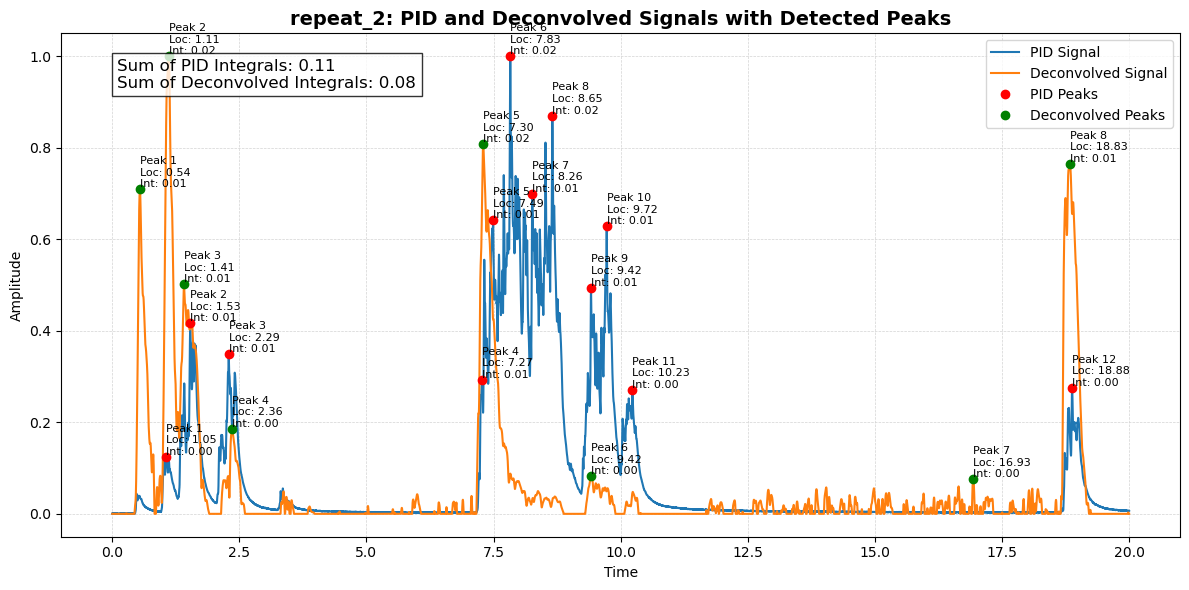

repeat_2 PID Dynamics (a, b, c): [(nan, nan, nan), (nan, nan, nan), (nan, nan, nan), array([-4.58237457e+02,  5.84874641e+01,  2.82261116e-01]), array([-109.38086183,   15.73824576,    0.60655419]), array([-29.51472667,   4.89819877,   0.93720172]), array([-255.44942783,   32.047658  ,    0.65699043]), array([-380.68661909,   44.13485789,    0.8140124 ]), array([-1.34016212e+03,  1.43446270e+02,  4.38946705e-01]), array([-1.46958188e+03,  1.52223506e+02,  5.71554714e-01]), array([-4.27038974e+03,  4.18630779e+02,  2.50042048e-01]), array([3.77493570e+05, 9.62069025e+03, 2.55723746e-01])]
repeat_2 Deconvolved Dynamics (a, b, c): [array([ 16.49875646,  -0.01652061, -15.94621648]), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), array([-33.94958786,   5.79036207,   0.79928269]), array([-1.89731189e+03,  2.60500154e+02,  8.16611465e-02]), array([-1.75756867e+05,  7.81522143e+04,  7.30145030e-02]), array([-2.93628126e+06,  4.11269234e+05,  7.62624304e-01])]


C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[1.060053   1.06105305 1.0620531  1.06305315 1.0640532  1.06505325
 1.0660533  1.06705335 1.0680534  1.06905345 1.0700535  1.07105355
 1.0720536  1.07305365 1.0740537  1.07505375 1.0760538  1.07705385
 1.0780539  1.07905395] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  integral = simpson(signal[left_base:right_base], t[left_base:right_base])
C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[1.59107955 1.5920796  1.59307965 1.5940797  1.59507975 1.5960798
 1.59707985 1.5980799  1.59907995 1.60008    1.60108005 1.6020801
 1.60308015 1.6040802  1.60508025 1.6060803  1.60708035 1.6080804
 1.60908045 1.6100805 ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, pass

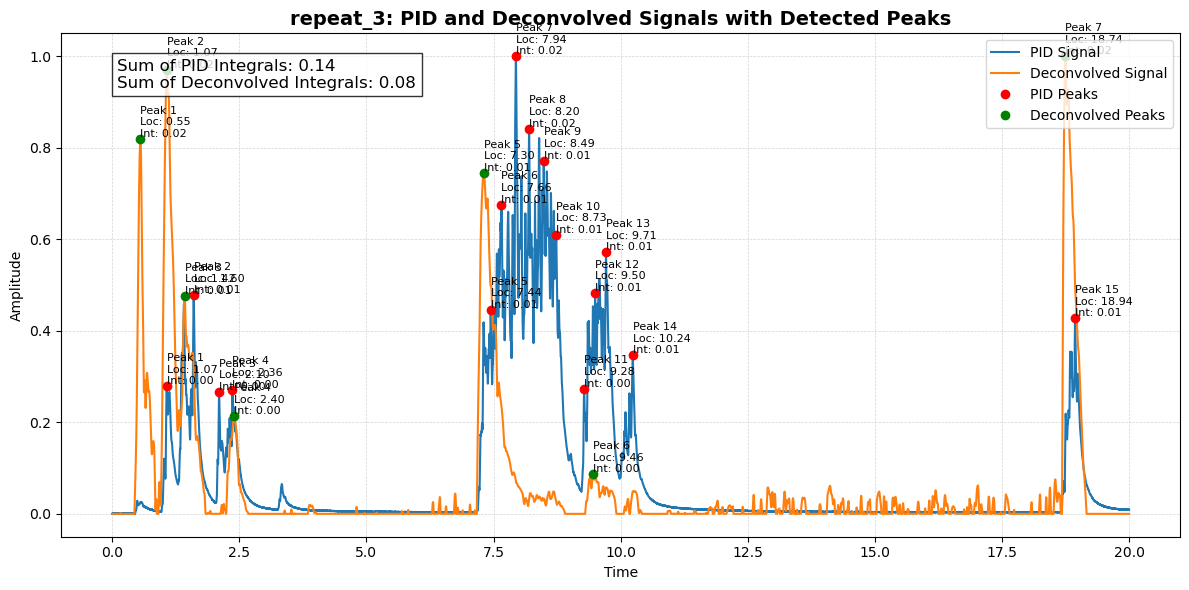

repeat_3 PID Dynamics (a, b, c): [(nan, nan, nan), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), array([-4.74866407e+02,  5.81583891e+01,  4.10799806e-01]), array([-48.90323269,   7.51923414,   0.65337304]), array([-47.56633233,   6.68595425,   0.95901301]), array([-142.83167024,   18.54484361,    0.79761152]), array([-303.35650093,   36.86737696,    0.72833354]), array([238.81112548,  11.07074685,   0.5832442 ]), array([-1.56837317e+03,  1.70115080e+02,  2.47617601e-01]), array([-1.50316374e+03,  1.59396340e+02,  4.37200681e-01]), array([-1.35886633e+03,  1.41046254e+02,  5.30296584e-01]), array([6.11645963e+04, 7.06968627e+03, 3.29166160e-01]), array([-2.93910599e+06,  1.84506129e+06,  3.90166525e-01])]
repeat_3 Deconvolved Dynamics (a, b, c): [array([ 1.79449226,  0.02401279, -0.95851607]), (nan, nan, nan), array([ 9.55517589,  0.01852534, -8.83641508]), (nan, nan, nan), array([-34.26762717,   5.82935278,   0.74295416]), array([-1.11837357e+03,  1.99361440e+02,  8.47814001e-02]

C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[0.56902845 0.5700285  0.57102855 0.5720286  0.57302865 0.5740287
 0.57502875 0.5760288  0.57702885 0.5780289  0.57902895 0.580029
 0.58102905 0.5820291  0.58302915 0.5840292  0.58502925 0.5860293
 0.58702935 0.5880294 ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  integral = simpson(signal[left_base:right_base], t[left_base:right_base])
C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[1.0680534  1.06905345 1.0700535  1.07105355 1.0720536  1.07305365
 1.0740537  1.07505375 1.0760538  1.07705385 1.0780539  1.07905395
 1.080054   1.08105405 1.0820541  1.08305415 1.0840542  1.08505425
 1.0860543  1.08705435] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passi

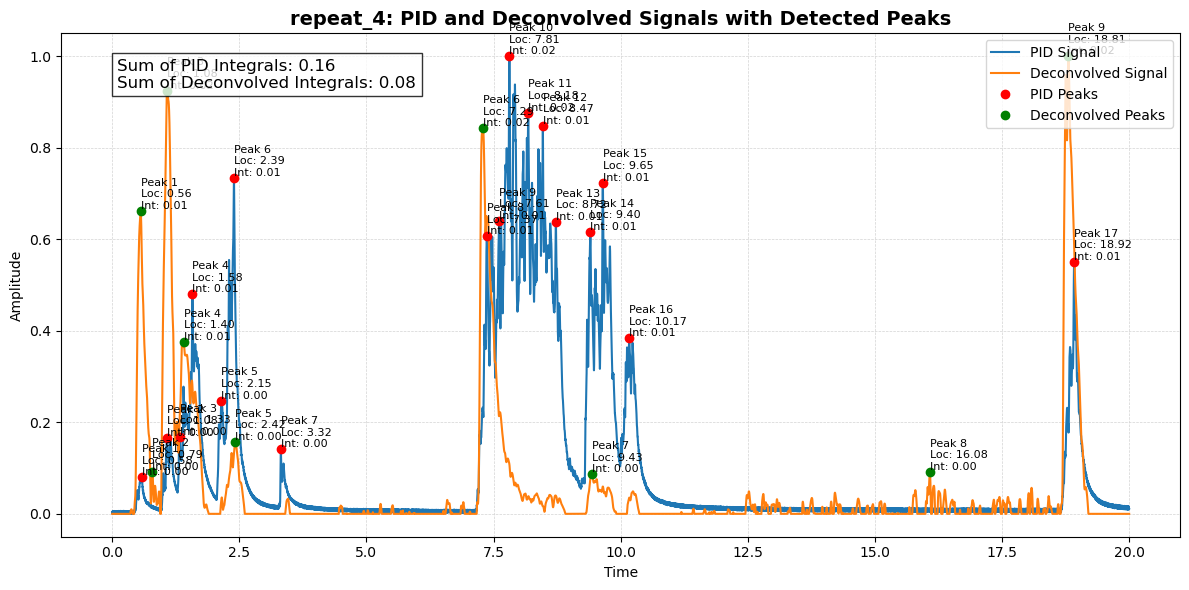

repeat_4 PID Dynamics (a, b, c): [(nan, nan, nan), array([ 3.50527310e+01,  1.35333001e-02, -3.43872763e+01]), array([ 11.70758462,   0.0164902 , -11.28892969]), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), array([-111.96679937,   16.33654769,    0.58274784]), array([-141.64140602,   19.75256048,    0.6065719 ]), array([-23.15925483,   4.09186796,   0.9501563 ]), array([-118.19604083,   15.56983387,    0.83329116]), array([-318.43821578,   38.7174981 ,    0.77558797]), array([5.86616010e+03, 8.26572915e+02, 6.04353974e-01]), array([366.90266711,  19.38521342,   0.59094224]), array([-1.02793304e+03,  1.07646647e+02,  6.77604942e-01]), array([-4.40115907e+03,  4.34059810e+02,  3.68085740e-01]), array([-2.09278064e+06,  1.37754080e+06,  4.97945818e-01])]
repeat_4 Deconvolved Dynamics (a, b, c): [array([ 1.50536678, -0.02140436, -0.8672285 ]), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), array([-23.00547463,   4.2939535 ,   0.84059465]), array(

C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[0.49502475 0.4960248  0.49702485 0.4980249  0.49902495 0.500025
 0.50102505 0.5020251  0.50302515 0.5040252  0.50502525 0.5060253
 0.50702535 0.5080254  0.50902545 0.5100255  0.51102555 0.5120256
 0.51302565 0.5140257 ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  integral = simpson(signal[left_base:right_base], t[left_base:right_base])
C:\Users\amirr\AppData\Local\Temp\ipykernel_12064\1707373692.py:16: DeprecationWarning: You are passing x=[1.0780539  1.07905395 1.080054   1.08105405 1.0820541  1.08305415
 1.0840542  1.08505425 1.0860543  1.08705435 1.0880544  1.08905445
 1.0900545  1.09105455 1.0920546  1.09305465 1.0940547  1.09505475
 1.0960548  1.09705485] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passi

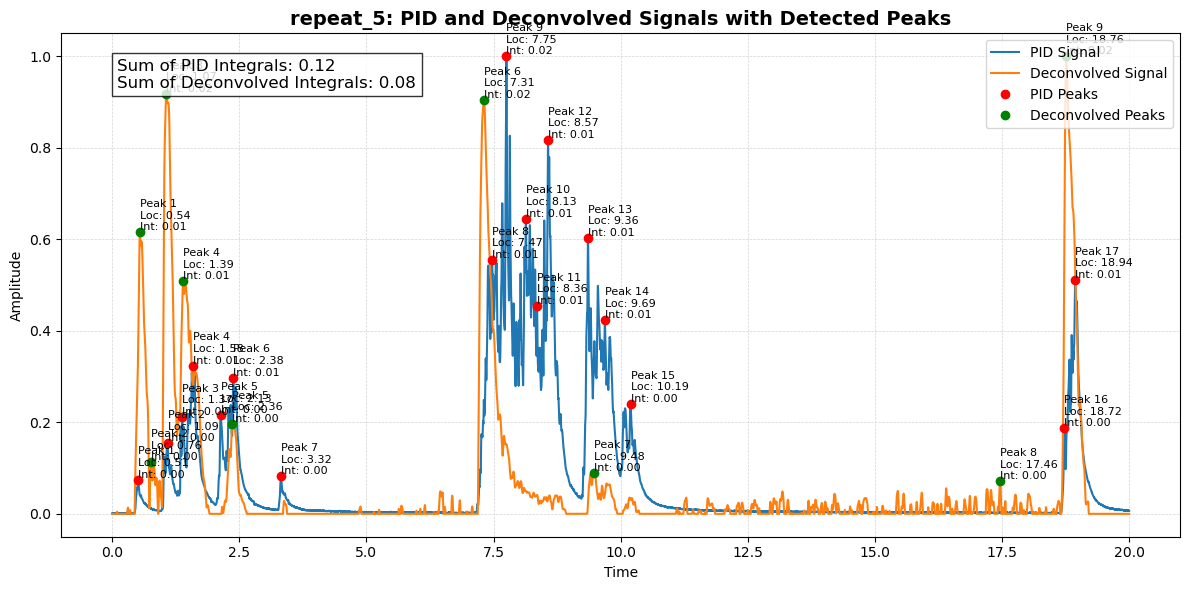

repeat_5 PID Dynamics (a, b, c): [array([-3.92600804e+70,  3.36463581e+02,  7.25834663e-02]), array([ 6.76144395e+01,  1.39436240e-02, -6.64506307e+01]), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), array([-169.28350908,   23.79402915,    0.51655036]), array([-41.52157485,   6.48521574,   0.90753082]), array([-235.4844305 ,   30.072794  ,    0.60069784]), array([-4.84959262e+02,  5.91641515e+01,  4.12037683e-01]), array([-373.37107563,   44.66704826,    0.75689114]), array([-2.05594997e+03,  2.09384991e+02,  5.60589672e-01]), array([-1.87976324e+03,  1.95141630e+02,  4.01645732e-01]), array([-1.39963020e+03,  2.66001052e+02,  2.34630147e-01]), array([-9.25593220e+05,  2.08899939e+06,  1.64602233e-01]), array([-6.86095050e+06,  1.23794791e+06,  4.92928588e-01])]
repeat_5 Deconvolved Dynamics (a, b, c): [array([-4.66942032e+91,  4.02395043e+02,  6.10200353e-01]), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), (nan, nan, nan), array([-61.7050052

In [11]:
#### Quantification of the Peaks and Dynamics
from scipy.signal import find_peaks
from scipy.integrate import simpson
from scipy.optimize import curve_fit

# Define the exponential function for fitting
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Function to calculate the integral below each peak
def calculate_integral(signal, peaks, t):
    integrals = []
    for peak in peaks:
        left_base = peak - 10 if peak - 10 >= 0 else 0
        right_base = peak + 10 if peak + 10 < len(signal) else len(signal) - 1
        integral = simpson(signal[left_base:right_base], t[left_base:right_base])
        integrals.append(integral)
    return integrals

# Function to fit exponential function to quantify rise and decay dynamics
def fit_dynamics(signal, peaks, t):
    dynamics = []
    for peak in peaks:
        left_base = peak - 10 if peak - 10 >= 0 else 0
        right_base = peak + 10 if peak + 10 < len(signal) else len(signal) - 1
        try:
            popt, _ = curve_fit(exp_func, t[left_base:right_base], signal[left_base:right_base], p0=(1, 1, 1), maxfev=10000)
            dynamics.append(popt)
        except RuntimeError as e:
            # print(f"Error fitting peak at index {peak}: {e}")
            dynamics.append((np.nan, np.nan, np.nan))
    return dynamics

# Assuming pid_normalized_repeats and deconvolved_normalized_repeats are already loaded and processed
# Example structure:
# pid_normalized_repeats = {
#     "repeat_1": np.array([...]),
#     "repeat_2": np.array([...])
# }
# deconvolved_normalized_repeats = {
#     "repeat_1": np.array([...]),
#     "repeat_2": np.array([...])
# }

# Process each repeat
height_P = 0.07
distance_P = 0.01 
prominence_P = 0.05
height_S = 0.07
distance_S = 0.01 
prominence_S = 0.05
for key, pid_data in pid_normalized_repeats.items():
    deconvolved_data = deconvolved_normalized_repeats[key]
    t = np.linspace(0, len(pid_data) / 1000, len(pid_data))  # Assuming a sampling rate of 1000 Hz
    
    # Detect peaks in the signals with specified parameters
    pid_peaks, _ = find_peaks(pid_data, height=height_P,
                              distance=distance_P * len(pid_data), prominence=prominence_P)
    deconvolved_peaks, _ = find_peaks(deconvolved_data, height=height_S, 
                                      distance=distance_S * len(deconvolved_data), prominence=prominence_S)
    
    # Calculate the integral below each peak
    pid_integrals = calculate_integral(pid_data, pid_peaks, t)
    deconvolved_integrals = calculate_integral(deconvolved_data, deconvolved_peaks, t)
    
    # Sum of all integrals
    pid_integral_sum = np.sum(pid_integrals)
    deconvolved_integral_sum = np.sum(deconvolved_integrals)
    
    # Fit exponential function to quantify rise and decay dynamics
    pid_dynamics = fit_dynamics(pid_data, pid_peaks, t)
    deconvolved_dynamics = fit_dynamics(deconvolved_data, deconvolved_peaks, t)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(t, pid_data, label='PID Signal', linewidth=1.5)
    plt.plot(t, deconvolved_data, label='Deconvolved Signal', linewidth=1.5)
    plt.plot(t[pid_peaks], pid_data[pid_peaks], 'ro', label='PID Peaks')
    plt.plot(t[deconvolved_peaks], deconvolved_data[deconvolved_peaks], 'go', label='Deconvolved Peaks')
    plt.title(f'{key}: PID and Deconvolved Signals with Detected Peaks', fontsize=14, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
    
    # Print the number of detected peaks, their locations, and integrals
    for i, peak in enumerate(pid_peaks):
        plt.text(t[peak], pid_data[peak], f'Peak {i+1}\nLoc: {t[peak]:.2f}\nInt: {pid_integrals[i]:.2f}', fontsize=8, verticalalignment='bottom')
    
    for i, peak in enumerate(deconvolved_peaks):
        plt.text(t[peak], deconvolved_data[peak], f'Peak {i+1}\nLoc: {t[peak]:.2f}\nInt: {deconvolved_integrals[i]:.2f}', fontsize=8, verticalalignment='bottom')
    
    # Print the sum of all integrals
    plt.text(0.05, 0.95, f'Sum of PID Integrals: {pid_integral_sum:.2f}\nSum of Deconvolved Integrals: {deconvolved_integral_sum:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print the rise and decay dynamics
    print(f"{key} PID Dynamics (a, b, c):", pid_dynamics)
    print(f"{key} Deconvolved Dynamics (a, b, c):", deconvolved_dynamics)